# Custom xG Models
This notebook trains two custom xG pipelines for shots from open play using Logistic Regression and Gradient Boosting Probability Trees on the following set of features:

`start_x_a0` :
    The x-coordinate of the shot  
`start_y_a0` :
    The y-coordinate of the shot  
`shot_angle_a0` :
    The angle of the shot  
`start_dist_to_goal_a0` :
    The distance to the center of the goal  
`bodypart_id_a0` :
    Bodypart used to take the shot (foot or head/other body part)  

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
from soccer_xg.api import DataApi
import soccer_xg.xg as xg
from soccer_xg.utils import sample_temporal

## Config


In [3]:
# dataset
dir_data = "../data"
provider = 'wyscout_opensource'
leagues = ['ENG', 'ESP', 'ITA', 'GER', 'FRA']
seasons = ['1718']

# features
store_features = f'../data/{provider}/features.h5'

Optionally, you can use dask to speed up the parameter tuning.

In [4]:
import dask
dask.config.set({'temporary_directory': '/tmp'})

cluster = False
#cluster = '134.58.41.90:8786'

if not cluster:
    from dask.distributed import Client
    client = Client(processes=False, threads_per_worker=4,
                    n_workers=1, memory_limit='2GB')
    
else:
    from dask.distributed import Client
    client = Client(cluster)
    
client

Client Scheduler: inproc://134.58.41.109/18671/1 Dashboard: http://134.58.41.109:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


## Preprocessing
We start by loading the raw SPADL data and precomputed features. Make sure to run the `1-load-and-convert-wyscout-data` and `3-computing-and-storing-features` notebooks first to download the data set, convert it to the SPADL format and compute the xG features.


### Load data

In [5]:
api = DataApi([f"{dir_data}/{provider}/spadl-{provider}-{l}-{s}.h5" 
        for (l,s) in itertools.product(leagues, seasons)])

### Load features

In [6]:
features = []
labels = []
# load features and labels for each season
for (l,s) in itertools.product(leagues, seasons):
    features.append(pd.read_hdf(store_features, key=f'{l}/{s}/features'))
    labels.append(pd.read_hdf(store_features, key=f'{l}/{s}/labels'))
features = pd.concat(features)
labels = pd.concat(labels)
# filter open play shots
open_play_idx = features[features.type_id_a0 == 'shot'].index
features = features.loc[open_play_idx]
labels = labels.loc[open_play_idx]

display(features.head())
display(labels.to_frame().head())

type_id_a0      type_id_a1 type_id_a2 bodypart_id_a0  \
game_id action_id                                                        
2500098 17              shot         dribble      cross           foot   
        40              shot  corner_crossed       pass           foot   
        77              shot       clearance      cross           foot   
        140             shot           cross    dribble           foot   
        145             shot            pass       pass           foot   

                  bodypart_id_a1 bodypart_id_a2 result_id_a1 result_id_a2  \
game_id action_id                                                           
2500098 17                  foot           foot      success      success   
        40                  foot           foot      success         fail   
        77                  foot           foot         fail         fail   
        140                 foot           foot      success      success   
        145                 foot           foot      success      success   

                   start_x_a0  start_y_a0  ...  speed_a02  shot_angle_a0  \
game_id action_id                          ...                             
2500098 17              99.75       26.52  ...   1.319750       0.499778   
        40              91.35       35.36  ...   4.249364       0.517985   
        77              75.60       29.92  ...   5.874066       0.242481   
        140             92.40       43.52  ...   2.061543       0.371538   
        145             99.75       37.40  ...   1.289870       0.978291   

                   shot_angle_a1  shot_angle_a2  caley_zone_a0  caley_zone_a1  \
game_id action_id                                                               
2500098 17              0.483780       0.065500              2              3   
        40              0.000000       0.363334              3              8   
        77              0.491555       0.043863              6              3   
        140             0.134860       0.167545              4              5   
        145             0.654611       0.320841              1              3   

                   caley_zone_a2  angle_zone_a0  angle_zone_a1  angle_zone_a2  
game_id action_id                                                              
2500098 17                     8              9             12             18  
        40                     4             12             21             12  
        77                     0             18             12             18  
        140                    0             12             15             18  
        145                    4              6              9             15  

[5 rows x 59 columns]

goal
game_id action_id       
2500098 17         False
        40         False
        77         False
        140        False
        145        False

### Split train - test
Create a train, validation (used for calibration) and test set (used for evalution).

In [7]:
games_train, games_val, games_test = sample_temporal(api, size_val=0.2, size_test=0.3)

X_train, y_train = features.loc[games_train], labels.loc[games_train]
data_train = X_train.assign(goal=y_train)
X_val, y_val = features.loc[games_val], labels.loc[games_val]
data_val = X_train.assign(goal=y_val)
X_test, y_test = features.loc[games_test], labels.loc[games_test]
data_test = X_test.assign(goal=y_test)

In [8]:
for name, X in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print("dataset =", name)
    print("shape =", X.shape)
    print("-" * 20)

dataset = train
shape = (20652, 59)
--------------------
dataset = val
shape = (7781, 59)
--------------------
dataset = test
shape = (11965, 59)
--------------------


## Learning

### Feature selection
Note that `a0` corresponds to the shot itself, `a1` would be the action before the shot, `a2` the action before that, etc.

In [9]:
NUM = ['start_x_a0', 'start_y_a0', 'start_dist_to_goal_a0', 'shot_angle_a0']  # numerical features
CAT = ['bodypart_id_a0']  # categorical features

### Logistic Regression

In [10]:
%autoreload 2
from soccer_xg.ml import logreg

In [11]:
search_logreg = logreg.logreg_gridsearch_classifier(
    numeric_features=NUM,
    categoric_features=CAT,
    use_dask=True,
    scoring='neg_brier_score',
    learning_rate='optimal',
    n_iter=1000
)

In [12]:
search_logreg.fit(X_train, y_train);

/home/pieterr/Jupiter/Projects/soccer_dataprovider_comparison/.venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 400 is smaller than n_iter=1000. Running 400 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [13]:
search_logreg.best_score_

-0.07954030983164834

No handles with labels found to put in legend.


{'max_dev': 43.84497552825291, 'residual_area': 766.1075845323285, 'roc': 0.781085666916153, 'brier': 0.08463387301843504, 'ece': 0.012483117426868794, 'ace': 0.012690942667727058, 'fig': <Figure size 720x360 with 3 Axes>}


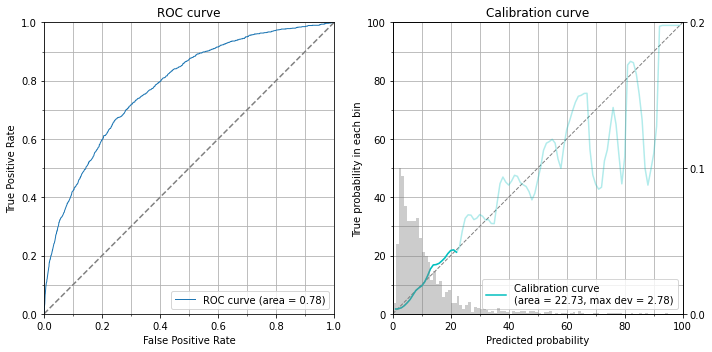

In [14]:
model = xg.OpenplayXGModel()
model.model = search_logreg.best_estimator_
model._training_seasons = ["1718"]
model._fitted = True
print(model.validate(data_test, validation_seasons=["1718"]))
model.save_model(f'{provider}_openplay_logreg_basic')

In [15]:
model = xg.XGModel.load_model(f'{provider}_logreg_basic')
(pd.DataFrame(
    data={'importance': model.model.named_steps['clf'].coef_[0]}, 
    index=CAT*2 + NUM)
    .sort_values(by='importance'))

,importance
bodypart_id_a0,-3.017892
bodypart_id_a0,-2.345470
start_dist_to_goal_a0,-0.683558
start_y_a0,-0.012526
start_x_a0,0.044673
shot_angle_a0,0.487839


### XGBoost

In [16]:
%autoreload 2
from soccer_xg.ml import xgboost

In [17]:
search_xgb = xgboost.xgboost_gridsearch_classifier(
    numeric_features=NUM,
    categoric_features=CAT,
    use_dask=True,
    scoring='neg_brier_score',
    n_iter=1000
)

In [18]:
search_xgb.fit(X_train, y_train);

In [19]:
search_xgb.best_score_

-0.0796168605722396

No handles with labels found to put in legend.


{'max_dev': 30.960270602527984, 'residual_area': 857.1900614979984, 'roc': 0.7823261149160066, 'brier': 0.08429739509683612, 'ece': 0.005332297751757049, 'ace': 0.008145586900316519, 'fig': <Figure size 720x360 with 3 Axes>}


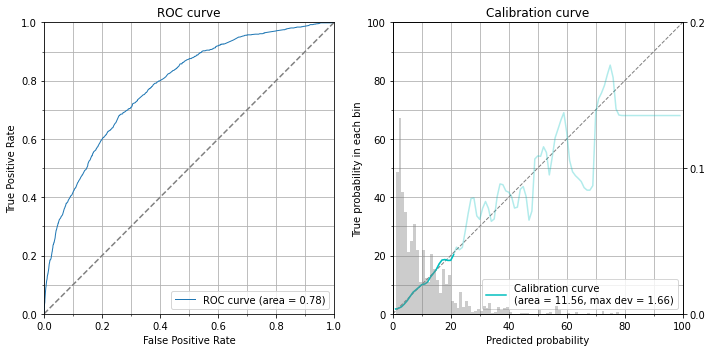

In [20]:
model = xg.OpenplayXGModel()
model.model = search_xgb.best_estimator_
model._training_seasons = ["1718"]
model._fitted = True
print(model.validate(data_test, validation_seasons=["1718"]))
model.save_model(f'{provider}_openplay_xgboost_basic')

#### Post calibration
Let's see if we can improve the model with post-calibration...

In [21]:
%autoreload 2
from soccer_xg.calibration import CalibratedClassifierCV

In [22]:
results = []

for method in [None, 'sigmoid', 'isotonic', 'beta', 'beta_am', 'beta_ab']:
    # calibrate
    calibrated_model = CalibratedClassifierCV(model.model, method=method, cv='prefit')
    calibrated_model.fit(X_val, y_val);
    # store
    model = xg.OpenplayXGModel()
    model.model = calibrated_model
    model._training_seasons = ["1718"]
    model._fitted = True
    # validate
    method = 'base' if method is None else method
    validation = model.validate(data_test, validation_seasons=["1718"], plot=False)
    validation['method'] = method
    results.append(validation)

pd.DataFrame(results).set_index('method').sort_values(by='ace')

,max_dev,residual_area,roc,brier,ece,ace,fig
method,,,,,,,
isotonic,39.564576,709.146478,0.781733,0.084732,0.008976,0.005764,None
beta,39.564332,709.137344,0.781733,0.084732,0.008976,0.005764,None
beta_ab,39.564904,709.146603,0.781733,0.084732,0.008976,0.005764,None
beta_am,39.564701,709.146401,0.781733,0.084732,0.008976,0.006127,None
base,30.960271,857.190061,0.782326,0.084297,0.005332,0.008269,None
sigmoid,45.334279,1358.774246,0.782326,0.085594,0.022263,0.026060,None


Apparently, post-calibration does not help here.

## xG heatmaps

In [23]:
%autoreload 2
import soccer_xg.features as fn
from soccer_xg.visualisation import plot_heatmap

### Shots by foot

In [24]:
start = np.array(list(itertools.product(np.arange(0, 106, 1), np.arange(0, 69, 1))))
df = pd.DataFrame({'start_x': start[:,0], 'start_y': start[:,1], 'bodypart_id': 'foot'})
df = pd.concat([
    fn.startlocation(df), 
    fn.startpolar(df),
    fn.bodypart(df),
    fn.goalangle(df),
], axis=1)

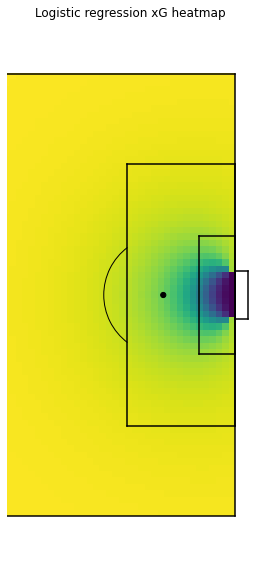

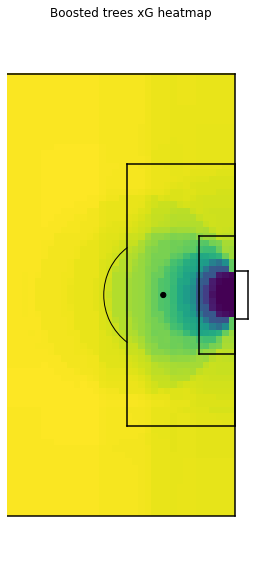

In [25]:
model = xg.XGModel.load_model(f'{provider}_openplay_logreg_basic')
ax0 = plot_heatmap(model, df, axis=None)
ax0.set_title('Logistic regression xG heatmap')

model = xg.XGModel.load_model(f'{provider}_openplay_xgboost_basic')
ax1 = plot_heatmap(model, df, axis=None);
ax1.set_title('Boosted trees xG heatmap')

plt.show()

### Headers

In [26]:
start = np.array(list(itertools.product(np.arange(0, 106, 1), np.arange(0, 69, 1))))
df = pd.DataFrame({'start_x': start[:,0], 'start_y': start[:,1], 'bodypart_id': 'head'})
df = pd.concat([
    fn.startlocation(df), 
    fn.startpolar(df),
    fn.bodypart(df),
    fn.goalangle(df),
], axis=1)

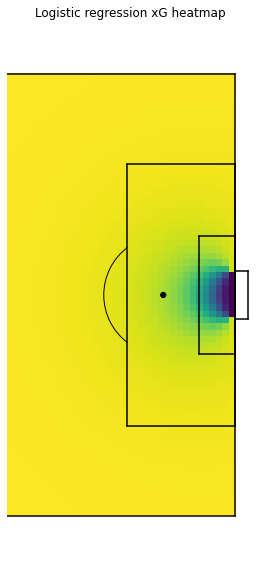

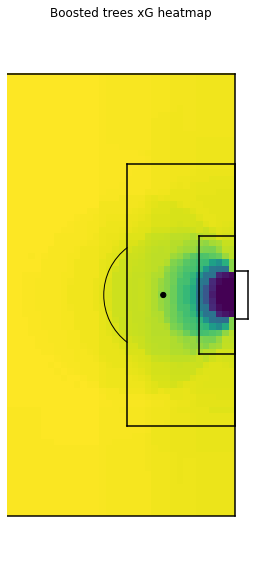

In [27]:
model = xg.XGModel.load_model(f'{provider}_openplay_logreg_basic')
ax0 = plot_heatmap(model, df, axis=None)
ax0.set_title('Logistic regression xG heatmap')

model = xg.XGModel.load_model(f'{provider}_openplay_xgboost_basic')
ax1 = plot_heatmap(model, df, axis=None);
ax1.set_title('Boosted trees xG heatmap')

plt.show()

## Combining custom models
In this notebook we've trained models that can only predict shots from open play. To be able to compute xG values from all shot types, you will have to combine them with other pipelines.

In [31]:
openplay_model = xg.XGModel.load_model(f'{provider}_openplay_xgboost_basic') # custom pipeline for openplay
penalty_model = xg.PenaltyXGModel() # default pipeline for penalties
freekick_model = xg.FreekickXGModel() # default pipeline for freekicks

model = xg.XGModel()
model.model = [openplay_model, penalty_model, freekick_model]

In [32]:
model.train(api, training_seasons=[('ESP', '1718'), ('ITA', '1718'), ('FRA', '1718'), ('GER', '1718')])

Generating labels: 100%|██████████| 1446/1446 [00:34<00:00, 41.82it/s]


Generating features: 100%|██████████| 380/380 [01:09<00:00,  5.49it/s]
No handles with labels found to put in legend.


{'max_dev': 29.633825426918392,
 'residual_area': 821.0990497947265,
 'roc': 0.7871554818983253,
 'brier': 0.08370078584210341,
 'ece': 0.006895048176804048,
 'ace': 0.005767807970400487,
 'fig': <Figure size 720x360 with 3 Axes>}

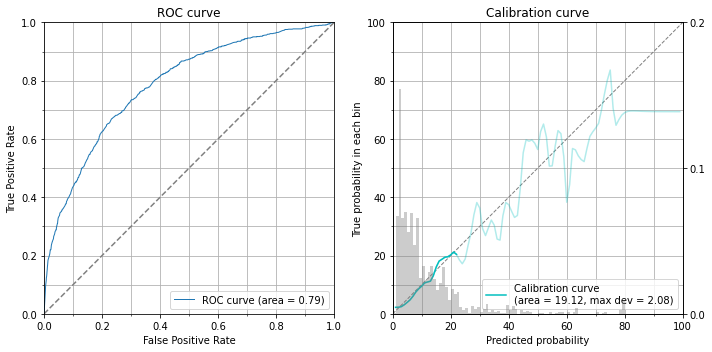

In [33]:
model.validate(api, validation_seasons=[('ENG', '1718')])